### 📄 Reference Paper  
**Title:** *Credit Card Fraud Detection Using Machine Learning and Deep Learning Techniques*  
**Link:** [Read on ResearchGate](https://www.researchgate.net/publication/347465411_Credit_Card_Fraud_Detection_using_Machine_Learning_and_Deep_Learning_Techniques)


# **By: Ahmed Ibrahim Foda 202202064**

# Importing Libraries & Dataset

In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d7985907fb37a9b3c60ca0bc04c55c2ba9e135e217ffec32be3f8c3e1838dba0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import lime.lime_tabular
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

| **Column Name**      | **Description**                                                                                                         |
|----------------------|-------------------------------------------------------------------------------------------------------------------------|
| `step`               | Time step — A unit of time in the simulation. 1 step = 1 hour. The simulation spans 744 steps (30 days).               |
| `type`               | Transaction type — One of: `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, or `TRANSFER`.                                  |
| `amount`             | Transaction amount — The amount of money moved in the transaction, in local currency.                                 |
| `nameOrig`           | Origin account ID — The ID of the customer/account initiating the transaction. Example: `C429214117`                  |
| `oldbalanceOrg`      | Origin account balance before — The balance of the origin account before the transaction.                             |
| `newbalanceOrig`     | Origin account balance after — The balance of the origin account after the transaction.                               |
| `nameDest`           | Destination account ID — The ID of the customer/account receiving the money. Merchant IDs often start with `M`.       |
| `oldbalanceDest`     | Destination balance before — The balance of the recipient account before the transaction.                             |
| `newbalanceDest`     | Destination balance after — The balance of the recipient account after the transaction.                               |
| `isFraud`            | Fraudulent transaction — `1` if the transaction was fraudulent, otherwise `0`.                                        |
| `isFlaggedFraud`     | Flagged by model — `1` if the transaction was flagged as potentially fraudulent (e.g., over 200,000 units), otherwise `0`. |


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the correct path to the file inside the dataset
file_path = "PS_20174392719_1491204439457_log.csv"

# Load the dataset
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ealaxi/paysim1",
  file_path,
)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Preprocessing

In [5]:
len(df)

6362620

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [9]:
print("\nFraud Distribution:")
print(df['isFraud'].value_counts())


Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [10]:
sns.set(style="whitegrid")

In [13]:
df["nameOrig"].nunique()

6353307

In [14]:
df["nameDest"].nunique()

2722362

In [15]:
len(df[df["nameOrig"] == df["nameDest"]])

0

### I will drop the features `nameOrig` & `nameDist` as they don't introduce any pattern also they are categorical and not ordinal features with unique values of `6353307` and `2722362` respictivly which means that after applying One-Hot Encoding we will have huge amount of 0,1 columns.

In [16]:
df.drop(columns=["nameOrig", "nameDest"],inplace=True)

### I will drop the feature `isFlaggedFraud` as it's a rule based pre-defined to flag a transaction as a fraud based on some rule which may cause data leakage

In [17]:
df.drop(columns=["isFlaggedFraud"],inplace=True)
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [18]:
df = pd.get_dummies(df, columns=['type'], prefix='type')

In [19]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [22]:
n_per_class_full = 100000
fraud_indices = np.random.choice(np.where(y_train_resampled == 1)[0], n_per_class_full, replace=False)
non_fraud_indices = np.random.choice(np.where(y_train_resampled == 0)[0], n_per_class_full, replace=False)
sample_indices = np.concatenate([fraud_indices, non_fraud_indices])
X_sampled = X_train_resampled.iloc[sample_indices]
y_sampled = y_train_resampled.iloc[sample_indices]

# Modeling

## Model Training & Testing

In [23]:
# Define the NN model
def create_nn_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer (sigmoid, not softmax)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [24]:
# Model Training
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)
# Create and train the model
nn_model = create_nn_model()
nn_model.fit(X_sampled, y_sampled, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8972 - loss: 2921.5029
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9460 - loss: 1001.1585
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9611 - loss: 296.0381
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9306 - loss: 170.4735
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9020 - loss: 106.6630
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


In [25]:
# Model Testing
y_pred_prob = nn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

39767/39767 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step


## Model Evaluation

In [26]:
# Calculate different accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Model Performance Metrics:
Accuracy: 0.9511
Precision: 0.0236
Recall: 0.9241
F1 Score: 0.0459


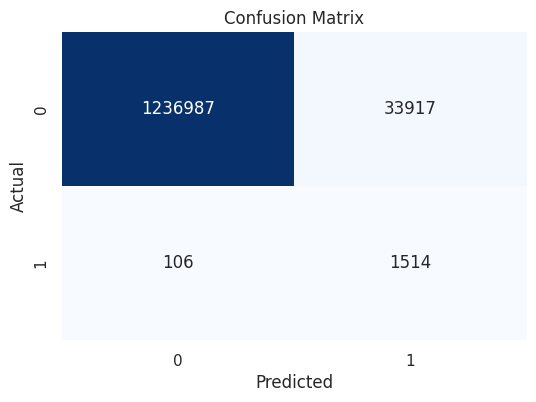

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### According to the performance metrics the model performance is not bad as the accuracy is really high `97%` but due to the class imbalance in the non-fraudlent records which are `1270904`it correctly predicted `1236987` correctly but failed in predicting the rest `33917` while the fraudlent records counting `1620` records it successfully predicted `1514` but missed `106`

# Explainability

## LIME Explanation

In [32]:
feature_names = X.columns

X_sampled_np = X_sampled.to_numpy().astype(np.float32)
X_test_np = X_test.to_numpy().astype(np.float32)

In [ ]:
def predict_proba_fn(X):
    probs_class_1 = nn_model.predict(X.astype(np.float32)).flatten()
    probs_class_0 = 1 - probs_class_1
    return np.vstack((probs_class_0, probs_class_1)).T

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_sampled_np,
    feature_names=feature_names,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

# Explain the same fraudulent transaction
exp = explainer.explain_instance(
    X_test_np[0],
    predict_proba_fn
)

print("\nLIME Explanation for a Fraudulent Transaction:")
exp.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LIME Explanation for a Fraudulent Transaction:


In [ ]:
y_test.iloc[fraud_idx]

np.int64(0)

### According to lime explaining this fraudelent record it shows that it's not-fraudlent by 100 % showing that it rely on this prediction on`newbalanceOrig`, `oldbalanceOrig` and `amount`.

## Permutation Importance

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return (self.model.predict(X.astype(np.float32)) > 0.5).astype(int)

    def predict_proba(self, X):
        probs = self.model.predict(X.astype(np.float32)).flatten()
        return np.vstack((1 - probs, probs)).T

wrapped_model = KerasWrapper(nn_model)

In [33]:
from sklearn.inspection import permutation_importance

subset_X = X_test_np[:100]
subset_y = y_test[:100]

results = permutation_importance(
    wrapped_model, subset_X, subset_y, n_repeats=5, random_state=42
)


print("\nPermutation Importance:")
for name, importance in zip(feature_names, results.importances_mean):
    print(f"{name}: {importance:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━

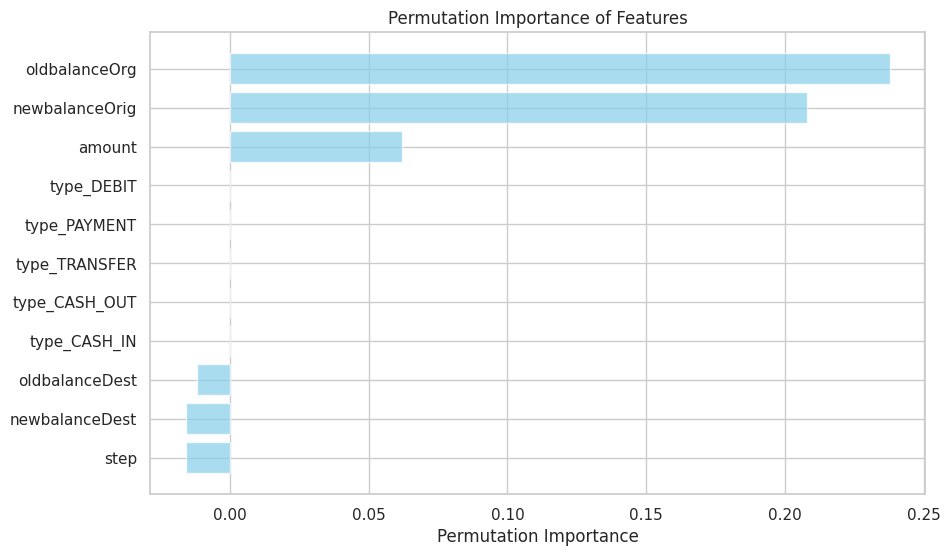

In [35]:
feature_names = np.array(X.columns)
importances = results.importances_mean

# Sort features by importance (descending)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, align="center", color="skyblue", alpha=0.7)
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.gca().invert_yaxis()
plt.show()

## PDP Plot

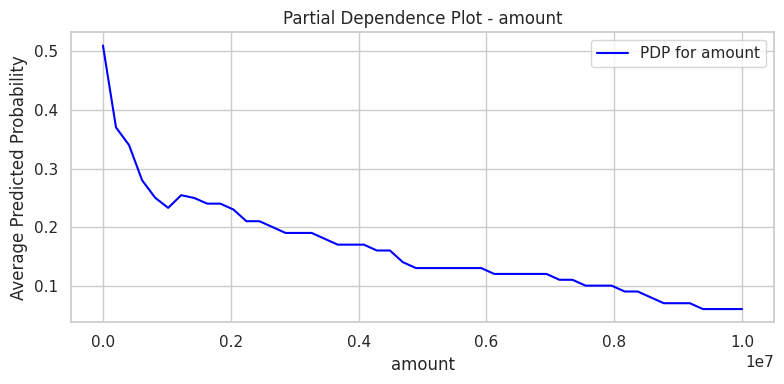

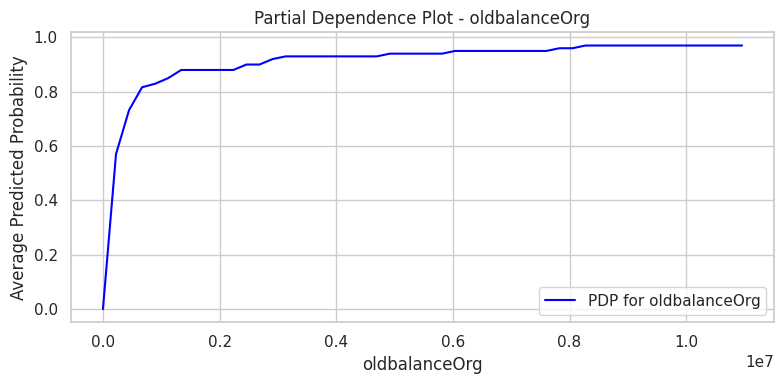

In [29]:
def compute_pdp(model, X, feature_name, grid_resolution=50):
    feature_values = np.linspace(X[feature_name].min(), X[feature_name].max(), grid_resolution)
    pdp_values = []

    X_temp = X.copy()
    for val in feature_values:
        X_temp[feature_name] = val
        preds = model.predict(X_temp, verbose=0)
        pdp_values.append(np.mean(preds))

    return feature_values, pdp_values

X_pdp = X_sampled.sample(n=100, random_state=42)

for feature in X_pdp.columns[1:3]:
    vals, pdp = compute_pdp(nn_model, X_pdp, feature)

    plt.figure(figsize=(8, 4))
    plt.plot(vals, pdp, label=f'PDP for {feature}', color='blue')
    plt.xlabel(feature)
    plt.ylabel('Average Predicted Probability')
    plt.title(f'Partial Dependence Plot - {feature}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### From the PDP Plot we can figure out that by increasing the `amount` the probability of being not fraud increases but in the oldbalanceOrg the opposite occurs.